In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

from deepeval import evaluate
from deepeval.evaluate import DisplayConfig, AsyncConfig
display_config = DisplayConfig(
    show_indicator=True,
    print_results=False,
    verbose_mode=False,
)
async_config = AsyncConfig(
    max_concurrent=1
)
import toml
with open('config.toml', 'r', encoding='utf-8') as toml_file:
    config = toml.load(toml_file)

model_names = config['model_names']
alter_names = model_names.copy() # Create a copy to modify

for i, name in enumerate(alter_names):
    if name in config['alternative_names']: 
        alter_names[i] = config['alternative_names'][name]

for name in alter_names:
    print(name)
INPUT_EXCEL_FILE = "goldens" / Path(config['QA_file_name'])
question_dfs = pd.read_excel(INPUT_EXCEL_FILE, sheet_name=None, index_col=0)
DOMAIN = list(question_dfs.keys())
num_questions_per_domain = question_dfs[DOMAIN[0]].shape[0]
print(f"共有{len(DOMAIN)}个领域，每个领域有{num_questions_per_domain}个问题")

QA_df = {}
for i, model in enumerate(model_names):
    QA_FILE = "QA" / Path(f"{model}_answers.xlsx")
    QA_df[model_names[i]] = pd.read_excel(QA_FILE, sheet_name=None, index_col=0)
from custom_metrics import get_dataset, correctness_metric, relevance_metric
from deepeval import evaluate
from deepeval.dataset import EvaluationDataset

DeepSeek-R1-Distill-Qwen-32B
DeepSeek-R1-Distill-Qwen-14B
deepseek/deepseek-r1
openai/gpt-4.1
openai/o3
anthropic/claude-sonnet-4
google/gemini-2.5-pro-preview
x-ai/grok-3-beta
共有13个领域，每个领域有10个问题


In [4]:
inference_model = model_names[1]
reference_answer = model_names[5]
case_dataset = get_dataset(
        infer_model=inference_model,
        ref_model=reference_answer,
        question_dataframe=question_dfs,
        QA_dataframe=QA_df,
        domains=DOMAIN
    )
evaluation_output = evaluate(case_dataset, 
                             [correctness_metric], 
                             display_config=display_config,
                             async_config=async_config,
                            #  hyperparameters={"Temperature": 0.1, "Max Tokens": 50000, "System Prompt": "You MUST NOT add any extra commentary outside the JSON"}
                             )

✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |▋         |  7% (9/130) [Time Taken: 04:00, 26.76s/test case]


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
evaluation_output.test_results[0].__dict__

{'name': 'test_case_11',
 'success': True,
 'metrics_data': [MetricData(name='正确率 (GEval)', threshold=0.5, success=True, score=0.8, reason='The Actual Output covers the derivation and dependencies of Grad-Shafranov equation but lacks explicit mention of specific physical quantities (e.g., Δ* operator) and boundary conditions from Expected Output. It also omits quantitative examples and stability analysis.', strict_mode=False, evaluation_model='deepseek-r1 (JSON)', error=None, evaluation_cost=None, verbose_logs='Criteria:\nNone \n \nEvaluation Steps:\n[\n    "检查最终结论是否与预期中的结论一致",\n    "推导思路相近但结论不同的情况，认为是错误的",\n    "如果出现公式和物理量，需要检查代表内容是否一致"\n] \n \nRubric:\nNone')],
 'conversational': False,
 'multimodal': False,
 'input': '导出并解释托卡马克等离子体平衡的Grad-Shafranov方程。讨论该方程的求解如何依赖于等离子体电流分布和压强分布，以及外部磁场线圈的配置。',
 'actual_output': '嗯，我现在要解释Grad-Shafranov方程，它在托卡马克等离子体平衡中的作用。首先，我记得Grad-Shafranov方程是描述等离子体在托卡马克中磁流体力学平衡的关键方程。它是一个二维的椭圆型偏微分方程，但具体是怎么推导出来的呢？\n\n我应该从托卡马克的磁配置开始，托卡马克通过环形的线圈产生外部磁场，加上等离子体自身的电流来维持等离子体的

In [ ]:
evaluation_output.test_results[0].metrics_data[0].__dict__

{'name': '正确率 (GEval)',
 'threshold': 0.5,
 'success': True,
 'score': 0.8,
 'reason': 'The Actual Output covers the derivation and dependencies of Grad-Shafranov equation but lacks explicit mention of specific physical quantities (e.g., Δ* operator) and boundary conditions from Expected Output. It also omits quantitative examples and stability analysis.',
 'strict_mode': False,
 'evaluation_model': 'deepseek-r1 (JSON)',
 'error': None,
 'evaluation_cost': None,
 'verbose_logs': 'Criteria:\nNone \n \nEvaluation Steps:\n[\n    "检查最终结论是否与预期中的结论一致",\n    "推导思路相近但结论不同的情况，认为是错误的",\n    "如果出现公式和物理量，需要检查代表内容是否一致"\n] \n \nRubric:\nNone'}

In [ ]:
evaluation_output_df = pd.DataFrame(
    [
        {
            "input": evaluation_output.test_results[i].input,
            "actual_output": evaluation_output.test_results[i].input,
            "expected_output": evaluation_output.test_results[i].expected_output,
            "score": evaluation_output.test_results[i].metrics_data[0].score,
            "reason": evaluation_output.test_results[i].metrics_data[0].reason,
        } 
    for i in range(len(evaluation_output.test_results))
    ])

In [ ]:
evaluation_output_df.head()

,input,actual_output,expected_output,score,reason
0,导出并解释托卡马克等离子体平衡的Grad-Shafranov方程。讨论该方程的求解如何依赖于...,导出并解释托卡马克等离子体平衡的Grad-Shafranov方程。讨论该方程的求解如何依赖于...,### 核心结论\nGrad-Shafranov方程描述了托卡马克中轴对称等离子体的力平衡，...,0.8,The Actual Output covers the derivation and de...
1,解释等离子体中的朗道阻尼机制。为何无碰撞等离子体中波会发生阻尼？它对等离子体加热和电流驱动有...,解释等离子体中的朗道阻尼机制。为何无碰撞等离子体中波会发生阻尼？它对等离子体加热和电流驱动有...,### 核心结论\n朗道阻尼是一种无碰撞等离子体中通过波粒相互作用实现的波能量转移过程，导致...,0.8,Actual Output provides a detailed explanation ...
2,讨论E×B漂移在等离子体约束和输运中的双重作用。以霍尔推进器或磁控溅射为例，分析闭合E×B漂...,讨论E×B漂移在等离子体约束和输运中的双重作用。以霍尔推进器或磁控溅射为例，分析闭合E×B漂...,### 核心结论\n\[ \mathbf{E} \times \mathbf{B} \] 漂...,0.8,Actual Output covers E×B drift's dual role and...
3,论述磁流体力学（MHD）近似的适用条件及其局限性。在哪些聚变等离子体现象的研究中，必须超越M...,论述磁流体力学（MHD）近似的适用条件及其局限性。在哪些聚变等离子体现象的研究中，必须超越M...,### 核心结论\nMHD近似适用于充分离子化、高β（等离子体压力与磁场压力之比）以及尺度远...,0.4,Actual Output lacks the structured format and ...
4,如何通过实验手段测量等离子体的基本参数，如电子温度（Te​）、离子温度（Ti​）、电子密度（...,如何通过实验手段测量等离子体的基本参数，如电子温度（Te​）、离子温度（Ti​）、电子密度（...,1. **核心结论** \n 等离子体的基本参数如电子温度、离子温度、电子密度和等离子...,0.5,The Actual Output discusses diagnostic techniq...


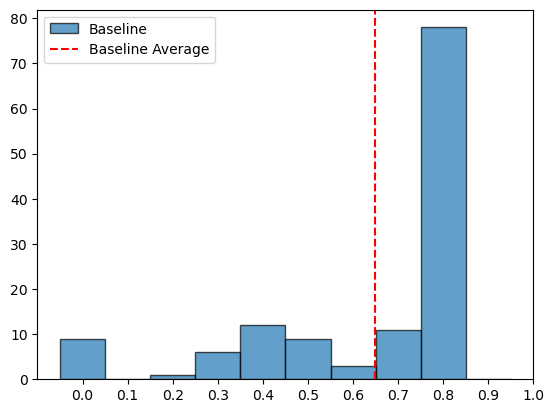

In [ ]:
from matplotlib import pyplot as plt
scores = evaluation_output_df['score'].tolist()
average_score = np.mean(scores)
bin_edges = np.arange(-0.05, 1.05, 0.1)
plt.hist(scores, bins=bin_edges, label='Baseline', edgecolor='black', alpha=0.7)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(average_score, color='r', linestyle='--', label='Baseline Average')
plt.legend()
plt.show()

In [ ]:
trained_inference_model = model_names[3]
reference_answer = model_names[5]
case_dataset = get_dataset(
        infer_model=trained_inference_model,
        ref_model=reference_answer,
        question_dataframe=question_dfs,
        QA_dataframe=QA_df,
        domains=DOMAIN
    )
trained_evaluation_output = evaluate(case_dataset, 
                             [correctness_metric], 
                             display_config=display_config,
                            #  hyperparameters={"Temperature": 0.1, "Max Tokens": 50000, "System Prompt": "You MUST NOT add any extra commentary outside the JSON"}
                             )

✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |          |  0% (0/130) [Time Taken: 00:01, ?test case/s]


InternalServerError: Error code: 502

In [ ]:
trained_evaluation_output_df = pd.DataFrame(
    [
        {
            "input": trained_evaluation_output.test_results[i].input,
            "actual_output": trained_evaluation_output.test_results[i].input,
            "expected_output": trained_evaluation_output.test_results[i].expected_output,
            "score": trained_evaluation_output.test_results[i].metrics_data[0].score,
            "reason": trained_evaluation_output.test_results[i].metrics_data[0].reason,
        } 
    for i in range(len(trained_evaluation_output.test_results))
    ])

In [ ]:
trained_scores = trained_evaluation_output_df['score'].tolist()
trained_average_score = np.mean(trained_scores)
bin_edges = np.arange(-0.05, 1.05, 0.1)
plt.hist(trained_scores, bins=bin_edges, label='Trained Model', edgecolor='black', alpha=0.5)
plt.hist(scores, bins=bin_edges, label='Baseline', edgecolor='black', alpha=0.5)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(trained_average_score, color='r', linestyle='--', label='Trained Model Average')
plt.axvline(average_score, color='b', linestyle='--', label='Baseline Average')
plt.legend()
plt.show()
